<a href="https://colab.research.google.com/github/JohanSH7/PROYECTO_SBERBANK_RUSSIAN_HOUSING_MARKET/blob/main/02%20-%20Modelos%20y%20analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importamos las Bibliotecas**


In [101]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()
! pip install kneed

In [102]:
#Bibliotecas y librerias necesarias
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster, mixture
from kneed import KneeLocator
import pandas as pd
import numpy as np
import seaborn as sns
from local.lib import calhousing as ch
import matplotlib.pyplot as plt
import gdown
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_log_error, log_loss, make_scorer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from progressbar import progressbar as pbar
from sklearn.tree import DecisionTreeRegressor

# **Preparamos los datos**


In [112]:
# Enlaces directos a los archivos en Google Drive
urls = {
    'train_final': 'https://drive.google.com/uc?id=1SDuXb0zIWnj2ZDPOuXjj-fXcghwbVeb4',
    'test_final': 'https://drive.google.com/uc?id=1QnfSJJC1l84fjeeHgl3Fffe0orrLPHj-',
}

# Descargar y leer cada archivo
dfs = {}
for name, url in urls.items():
    output = f"{name}.csv"
    gdown.download(url, output, quiet=False)
    dfs[name] = pd.read_csv(output)

# Ahora las siguientes variables contienen los DataFrames correspondientes a cada archivo
DF = dfs['train_final']
Test = dfs['test_final']


Downloading...
From: https://drive.google.com/uc?id=1SDuXb0zIWnj2ZDPOuXjj-fXcghwbVeb4
To: /content/train_final.csv
100%|██████████| 57.9M/57.9M [00:00<00:00, 267MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QnfSJJC1l84fjeeHgl3Fffe0orrLPHj-
To: /content/test_final.csv
100%|██████████| 14.4M/14.4M [00:00<00:00, 222MB/s]


Elegimos unos cuantos registros puesto que al entrenar los modelos el tiempo de ejecucion es demasiado extenso

In [113]:
# Para el conjunto de datos DF
X = DF.sample(n=10000, random_state=42)  # Elige un valor apropiado para random_state

# **Separamos la variable a predecir**

In [114]:
y = X['price_doc']
x = X.drop(['price_doc'], axis=1)

In [66]:
print(x.shape, y.shape, Test.shape)

(10000, 450) (10000,) (7662, 450)


# **Modelo Supervisado**

Definimos la metrica de desempeño

In [85]:
def rmlse(estimator, X, y):
    preds = estimator.predict(X)
    relative_errors = np.log1p(preds) - np.log1p(y)
    squared_errors = relative_errors**2
    mean_squared_error = np.mean(squared_errors)
    rmlse = np.sqrt(mean_squared_error)
    return rmlse

Separamos los datos en train y validacion

In [68]:
Xtr, Xts, ytr, yts = train_test_split(x,y, test_size=0.3)
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(7000, 450) (7000,) (3000, 450) (3000,)


Entrenamos los modelos a evaluar (RandomForest, SuportVectorMachine, DecisionTree)

In [77]:
rf = RandomForestRegressor(n_estimators=5, max_depth=10)
rf.fit(Xtr,ytr)

svr = SVR(gamma=2)
svr.fit(Xtr, ytr)

dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(Xtr, ytr)

DecisionTreeRegressor(max_depth=5)

Evaluamos con nuestra metrica de desempeño

In [82]:
print(rmlse(rf, Xtr, ytr), rmlse(rf, Xts, yts))

0.39867161832679193 0.4765729068615031


In [81]:
print(rmlse(svr, Xtr, ytr), rmlse(svr, Xts, yts))

0.6051424857685843 0.5900018695540759


In [83]:
print(rmlse(dtr, Xtr, ytr), rmlse(dtr, Xts, yts))

0.4896266179969588 0.49224113337258274


Evaluamos las metricas con cross-validation.

In [86]:
z = cross_val_score(rf, x, y, cv = ShuffleSplit(n_splits=10, test_size=0.3), scoring=rmlse)
print (z)
print ("test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))

[0.50537727 0.48823242 0.46170753 0.4930086  0.45705083 0.46481507
 0.48069792 0.49249753 0.48419297 0.49262655]
test score  0.482 (±0.0151)


El siguiente codigo es el analisis para el modelo SVR, no se pone en bloque de codigo, por tiempo de ejecucion.

z = cross_val_score(svr, x, y, cv = ShuffleSplit(n_splits=5, test_size=0.3), scoring=rmlse)
print (z)
print ("test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))
*****
[0.60756651 0.5879302  0.59375958 0.61269421 0.59700581]

test score  0.600 (±0.0091)

In [88]:
z = cross_val_score(dtr, x, y, cv = ShuffleSplit(n_splits=10, test_size=0.3), scoring=rmlse)
print (z)
print ("test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))

[0.48947823 0.48791437 0.51439166 0.48740191 0.5252822  0.5143389
 0.51425814 0.49133538 0.48656893 0.48637485]
test score  0.500 (±0.0145)


Curvas de aprendizaje

**Nota:** Duran aproximadamente 1 minuto en ejecucion.

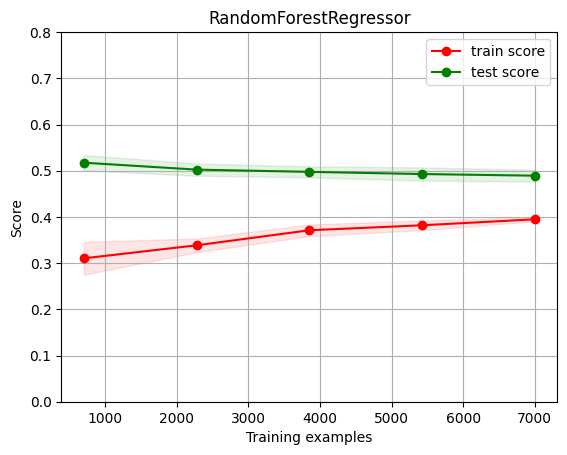

In [97]:
cv = ShuffleSplit(n_splits=10, test_size=.3)
ch.plot_learning_curve(rf, rf.__class__.__name__, x, y,
                       cv=cv, scoring=rmlse, ylim=(0,0.8))

**Nota:** El siguiente modelo tardo 10 minutos en ejecucion.

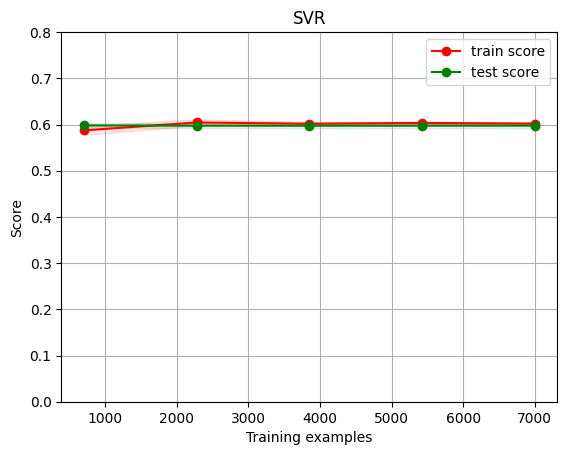

In [98]:
cv = ShuffleSplit(n_splits=5, test_size=.3)
ch.plot_learning_curve(svr, svr.__class__.__name__, x, y,
                       cv=cv, scoring=rmlse, ylim=(0,0.8))

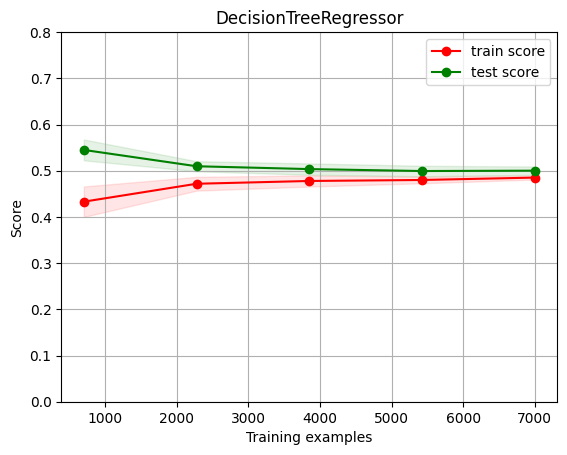

In [99]:
cv = ShuffleSplit(n_splits=10, test_size=.3)
ch.plot_learning_curve(dtr, dtr.__class__.__name__, x, y,
                       cv=cv, scoring=rmlse, ylim=(0,0.8))

# **Modelos No Supervisados**

## **Analisamos la cantidad de componentes optima para el proyecto**

Debido a la alta dimensionalidad, es necesario aplicar una tecnica de reduccion de dimensionalidad y de esta forma mejorar la eficiencia en cuanto a tiempo de ejecucion.

Número de Componentes: 1, Varianza Acumulativa Explicada: 21.25%
Número de Componentes: 21, Varianza Acumulativa Explicada: 58.30%
Número de Componentes: 41, Varianza Acumulativa Explicada: 67.91%
Número de Componentes: 61, Varianza Acumulativa Explicada: 74.27%
Número de Componentes: 81, Varianza Acumulativa Explicada: 79.42%
Número de Componentes: 101, Varianza Acumulativa Explicada: 84.13%
Número de Componentes: 121, Varianza Acumulativa Explicada: 88.68%
Número de Componentes: 141, Varianza Acumulativa Explicada: 93.18%
Número de Componentes: 161, Varianza Acumulativa Explicada: 96.77%
Número de Componentes: 181, Varianza Acumulativa Explicada: 98.50%
Número de Componentes: 201, Varianza Acumulativa Explicada: 99.26%
Número de Componentes: 221, Varianza Acumulativa Explicada: 99.64%
Número de Componentes: 241, Varianza Acumulativa Explicada: 99.82%
Número de Componentes: 261, Varianza Acumulativa Explicada: 99.91%
Número de Componentes: 281, Varianza Acumulativa Explicada: 99.96%
N

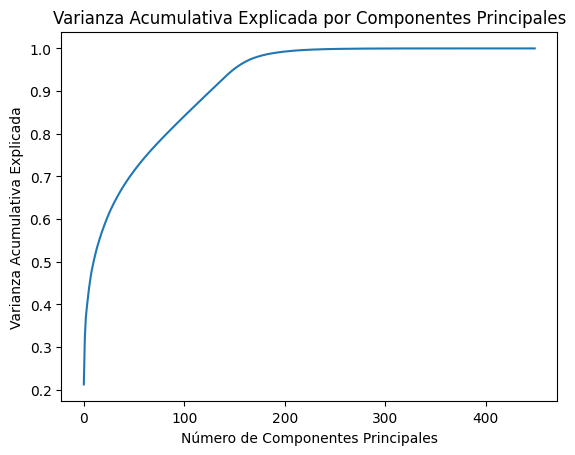

In [106]:

# Escala los datos para tener media cero y varianza unitaria
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Encuentra el número óptimo de componentes
pca = PCA()
pca.fit(x_scaled)

# Calcula la varianza acumulativa explicada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Imprime el porcentaje de varianza acumulativa para cada componente
for i in range(0, len(cumulative_variance), 20):
    print(f'Número de Componentes: {i + 1}, Varianza Acumulativa Explicada: {cumulative_variance[i] * 100:.2f}%')

# Grafica la varianza acumulativa explicada
plt.plot(cumulative_variance)
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.title('Varianza Acumulativa Explicada por Componentes Principales')
plt.show()

PCA - Random Forest

In [118]:
# Número de componentes para PCA
n_components = 101  # Puedes cambiar este valor al número específico que necesitas

# Aplicar PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(x)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Definir el modelo Random Forest
regressor = RandomForestRegressor( max_depth=5)

# Entrenar el modelo
regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = regressor.predict(X_test)

# Calcular el RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

# Imprimir el resultado
print(f"RMSLE con {n_components} componente(s): {rmsle}")

RMSLE con 101 componente(s): 0.5237447190090955


K-Means Clustering - Regresión Lineal y Random Forest

In [119]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Número de clústeres (ajústalo según tus necesidades)
n_clusters = 3

# Aplicar K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(x)

# Agregar la asignación de clústeres como una nueva característica
X_clustered = np.column_stack((X, clusters))

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_clustered, y, test_size=0.3, random_state=42)

# Modelo supervisado - Regresión Lineal
regressor_lr = LinearRegression()
regressor_lr.fit(X_train, y_train)
y_pred_lr = regressor_lr.predict(X_test)

# Calcular RMSLE
rmsle_lr = np.sqrt(mean_squared_log_error(y_test, y_pred_lr))
print(f"RMSLE con K-Means + Regresión Lineal: {rmsle_lr}")

# Modelo supervisado - Random Forest
regressor_rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
regressor_rf.fit(X_train, y_train)
y_pred_rf = regressor_rf.predict(X_test)

# Calcular RMSLE
rmsle_rf = np.sqrt(mean_squared_log_error(y_test, y_pred_rf))
print(f"RMSLE con K-Means + Random Forest: {rmsle_rf}")


RMSLE con K-Means + Regresión Lineal: 3.589237313069348e-15
RMSLE con K-Means + Random Forest: 0.009861334444173355


Curvas de aprendizaje

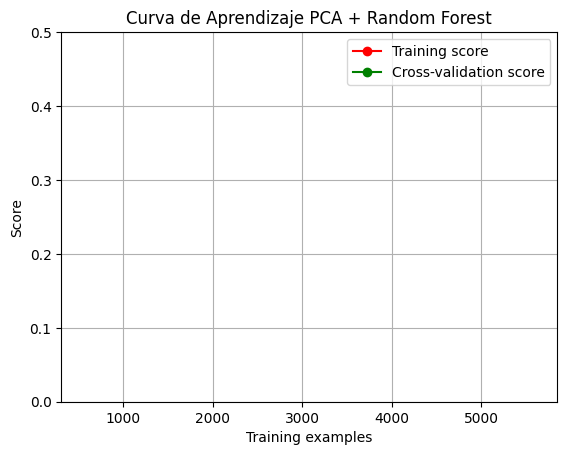

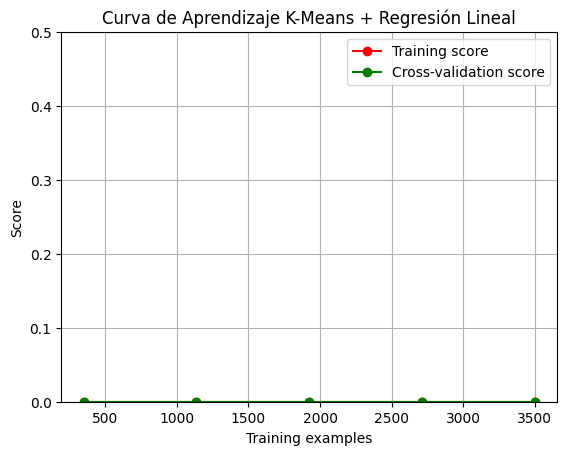

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve, train_test_split

# Función para visualizar curvas de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_log_error')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# PCA + Random Forest
n_components = 101  # Ajusta según tus necesidades
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

estimator_pca_rf = RandomForestRegressor(max_depth=5)

title = "Curva de Aprendizaje PCA + Random Forest"
plot_learning_curve(estimator_pca_rf, title, X_train, y_train, ylim=(0, 0.5), cv=5, n_jobs=-1)

# K-Means + Regresión Lineal
n_clusters = 3  # Ajusta según tus necesidades
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

X_clustered = np.column_stack((X, clusters))
X_train, X_test, y_train, y_test = train_test_split(X_clustered, y, test_size=0.3, random_state=42)

estimator_kmeans_lr = LinearRegression()

title = "Curva de Aprendizaje K-Means + Regresión Lineal"
plot_learning_curve(estimator_kmeans_lr, title, X_train, y_train, ylim=(0, 0.5), cv=2)

plt.show()
